In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Хоть нам и не нужно тут ничего обучать, GPU всё равно не помешает: чем мельче будут шаги, тем лучше получится результат.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget http://russian7.ru/wp-content/uploads/2016/06/2d7490c861cb1f86c5c727fde4584c90.jpeg
!wget https://www.zvuki.ru/images/photo/65/65177.jpg

--2022-04-07 09:21:51--  http://russian7.ru/wp-content/uploads/2016/06/2d7490c861cb1f86c5c727fde4584c90.jpeg
Resolving russian7.ru (russian7.ru)... 5.188.57.51
Connecting to russian7.ru (russian7.ru)|5.188.57.51|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://russian7.ru/wp-content/uploads/2016/06/2d7490c861cb1f86c5c727fde4584c90.jpeg [following]
--2022-04-07 09:21:52--  https://russian7.ru/wp-content/uploads/2016/06/2d7490c861cb1f86c5c727fde4584c90.jpeg
Connecting to russian7.ru (russian7.ru)|5.188.57.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87414 (85K) [image/jpeg]
Saving to: ‘2d7490c861cb1f86c5c727fde4584c90.jpeg’

2d7490c861cb1f86c5c 100%[===================>]  85.37K   324KB/s    in 0.3s    

2022-04-07 09:21:53 (324 KB/s) - ‘2d7490c861cb1f86c5c727fde4584c90.jpeg’ saved [87414/87414]

--2022-04-07 09:21:53--  https://www.zvuki.ru/images/photo/65/65177.jpg
Resolving www.zvuki.ru (www.zvuki.ru)... 

In [ ]:
# уменьшаем картинки
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize), # уменьшаем картинку
    transforms.ToTensor()])  # делаем из картинки тензор


def image_loader(image_name):
    image = Image.open(image_name)
    image = image.resize([700, 800])
    # создаем фейковый дименшн для батча
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./2d7490c861cb1f86c5c727fde4584c90.jpeg")
content_img = image_loader("./65177.jpg")

assert style_img.size() == content_img.size(), \
    "Картинки для стиля и для контента должны быть одного размера"

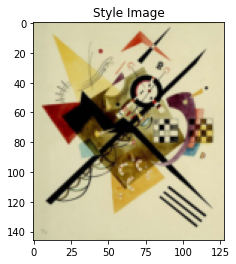

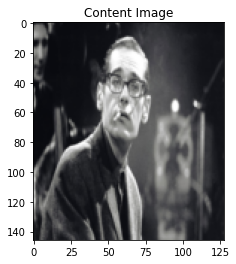

In [ ]:
unloader = transforms.ToPILImage()  # конвертируем в `PIL image`

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      # убираем лишнюю размерность батча
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        # detach() используется, чтобы не считать градиенты до target
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# upd: возможно, эта штука уже есть где-то в pytorch

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# upd: эта штука тоже уже должна быть где-нибудь в pytorch

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Делаем модуль для нормализации, чтобы потом без труда стакать в слои
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
# Какие именно слои мы хотим использовать чтобы считать наши лоссы
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # помним, что сначала нормализуем картинки
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # хотим иметь iterable с вставленными модулями
    content_losses = []
    style_losses = []

    # создаем свою модельку, в которую вставим лоссы
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # добавляем content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # добавляем style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Обрезаем все слои, которые находятся после последнего ContentLoss или StyleLoss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
    # input_img - это параметры, до которых доходит градиент
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=320,
                       style_weight=1000000, content_weight=1):
    """ Поехали! """
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                     normalization_std,
                                                                     style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # корректируем значения, чтобы они лежали в пределах `[0..1]`
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # корректируем значения, чтобы они лежали в пределах `[0..1]` для финальной картинки
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Optimizing..
run [50]:
Style Loss : 734.046814 Content Loss: 30.965380

run [100]:
Style Loss : 337.346741 Content Loss: 34.745667

run [150]:
Style Loss : 221.217545 Content Loss: 36.773319

run [200]:
Style Loss : 172.723297 Content Loss: 38.132999

run [250]:
Style Loss : 140.253983 Content Loss: 38.963779

run [300]:
Style Loss : 115.832367 Content Loss: 39.845638



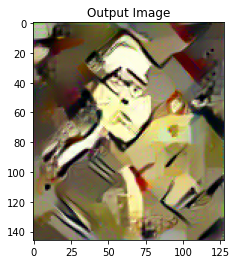

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# plt.figure()
imshow(output, title='Output Image')

# plt.ioff()
plt.show()